In [1]:
from pyscf import gto, scf, cc
import numpy as np
from jax import numpy as jnp
from jax import vmap, jvp, jit
import jax
from functools import partial

a = 2 # 2aB
nH = 2
atoms = ""
for i in range(nH):
    atoms += f"N {i*a:.5f} 0.00000 0.00000 \n"

mol = gto.M(atom=atoms, basis="sto6g", unit='B', spin=0, verbose=4)
mol.build()

mf = scf.UHF(mol)
mf.kernel()

mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)
mo = mf.stability()[0]
dm = mf.make_rdm1(mo,mf.mo_occ)
mf.kernel(dm0=dm)


nfrozen = 0
mycc = cc.CCSD(mf,frozen=nfrozen)
mycc.kernel()[0]

et = mycc.ccsd_t()

System: uname_result(system='Linux', node='yichi-thinkpad', release='4.4.0-26100-Microsoft', version='#7309-Microsoft Fri Jan 01 08:00:00 PST 2016', machine='x86_64')  Threads 12
Python 3.10.16 | packaged by conda-forge | (main, Dec  5 2024, 14:16:10) [GCC 13.3.0]
numpy 1.24.3  scipy 1.14.1  h5py 3.12.1
Date: Sun Feb  1 19:10:34 2026
PySCF version 2.8.0
PySCF path  /home/yichi/research/software/lno_pyscf
GIT HEAD (branch master) ef75f4190e4de208685670651dc6c467f72b6794

[ENV] PYSCF_EXT_PATH /home/yichi/research/software/pyscf
[CONFIG] conf_file None
[INPUT] verbose = 4
[INPUT] num. atoms = 2
[INPUT] num. electrons = 14
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = B
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 N      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0.000000000000   0.00000000

In [2]:
options = {'n_eql': 3,
           'n_prop_steps': 50,
            'n_ene_blocks': 1,
            'n_sr_blocks': 5,
            'n_blocks': 10,
            'n_walkers': 50,
            'seed': 2,
            'walker_type': 'uhf',
            'trial': 'uhf',
            'free_projection': True,
            'dt':0.01,
            'use_gpu': False
            }

from ad_afqmc import pyscf_interface
pyscf_interface.prep_afqmc(mycc,options,chol_cut=1e-5)

option_file='options.bin'
import pickle
with open(option_file, 'wb') as f:
    pickle.dump(options, f)

#
# Preparing AFQMC calculation
# If you import pyscf cc modules and use MPI for AFQMC in the same script, finalize MPI before calling the AFQMC driver.
# Calculating Cholesky integrals
# Finished calculating Cholesky integrals
#
# Size of the correlation space:
# Number of electrons: (7, 7)
# Number of basis functions: 10
# Number of Cholesky vectors: 42
#


In [3]:
import numpy as np
from jax import random
from jax import numpy as jnp
from functools import partial
from ad_afqmc import config
from ad_afqmc import mpi_jax

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64


In [4]:
config.setup_jax()
MPI = config.setup_comm()
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

print = partial(print, flush=True)

ham_data, ham, prop, trial, wave_data, sampler, observable, options, _ = (mpi_jax._prep_afqmc())

# Hostname: yichi-thinkpad
# System Type: Linux
# Machine Type: x86_64
# Processor: x86_64
# Number of MPI ranks: 1
#
# norb: 10
# nelec: (7, 7)
#
# n_eql: 3
# n_prop_steps: 50
# n_ene_blocks: 1
# n_sr_blocks: 5
# n_blocks: 10
# n_walkers: 50
# seed: 2
# walker_type: uhf
# trial: uhf
# free_projection: True
# dt: 0.01
# use_gpu: False
# n_exp_terms: 6
# orbital_rotation: True
# do_sr: True
# symmetry: False
# save_walkers: False
# ene0: 0.0
# n_batch: 1
# LNO: False
# orbE: 0
# maxError: 0.001
#


In [17]:
from ad_afqmc import linalg_utils
from jax import lax
import jax
from jax import numpy as jnp

@jit
def uwalker_norm(
    walker_up: jax.Array,
    walker_dn: jax.Array,
) -> float:
    norm = jnp.linalg.det(walker_up.T.conj() @ walker_up
        ) * jnp.linalg.det(walker_dn.T.conj() @ walker_dn)
    return jnp.real(norm)


@jit
def qr_walker_uhf(walker_up, walker_dn):
    nocc_up = walker_up.shape[1]
    nocc_dn = walker_dn.shape[1]
    q_up, r_up = jnp.linalg.qr(walker_up)
    q_dn, r_dn = jnp.linalg.qr(walker_dn)
    norm_up = jnp.sqrt(
        jnp.real(
            jnp.linalg.det(r_up[:,:nocc_up].conj().T @ r_up[:,:nocc_up])
            )
        )
    norm_dn = jnp.sqrt(
        jnp.real(
            jnp.linalg.det(r_dn[:,:nocc_dn].conj().T @ r_dn[:,:nocc_dn])
            )
        )
    return (q_up, q_dn), norm_up * norm_dn

def qr_walkers_uhf(walkers):
    (walkers_up, walkers_dn), norms \
        = vmap(qr_walker_uhf, in_axes=(0, 0))(walkers[0], walkers[1])
    return (walkers_up, walkers_dn), norms

@jit
def stochastic_reconfiguration_uhf(walkers, weights, zeta):
    nwalkers = walkers[0].shape[0]
    cumulative_weights = jnp.cumsum(jnp.abs(weights))
    total_weight = cumulative_weights[-1]
    average_weight = total_weight / nwalkers
    weights = jnp.ones(nwalkers, dtype=jnp.complex128) * average_weight
    z = total_weight * (jnp.arange(nwalkers) + zeta) / nwalkers
    indices = vmap(jnp.searchsorted, in_axes=(None, 0))(cumulative_weights, z)
    walkers[0] = walkers[0][indices]
    walkers[1] = walkers[1][indices]
    return walkers, weights

@partial(jit, static_argnums=(0))
def propagate_free(prop, ham_data, prop_data, fields):
    shift_term = jnp.einsum("wg,sg->sw", fields, ham_data["mf_shifts_fp"])
    constants = jnp.einsum(
        "sw,s->sw",
        jnp.exp(-jnp.sqrt(prop.dt) * shift_term),
        jnp.exp(prop.dt * ham_data["h0_prop_fp"]),
    )
    prop_data["walkers"] = prop._apply_trotprop(
        ham_data, prop_data["walkers"], fields
    )
    prop_data["walkers"] = prop._multiply_constant(prop_data["walkers"], constants)
    
    # prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    # weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    # weights = jnp.real(norms[0] * norms[1])
    # nwalker = int(prop_data["weights"].shape[0])
    # prop_data["weights"] *= weights
    # prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    # prop_data["weights"] *= prop_data["overlaps"]
    # prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    return prop_data


# @partial(jit, static_argnums=(3))
# def fp_step(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     return prop_data, fields

# @partial(jit, static_argnums=(3))
# def fp_step_qr(prop_data, fields, ham_data, prop):
#     """A Free propagation step of nwalkers"""
#     prop_data = propagate_free(prop, ham_data, prop_data, fields)
#     (prop_data["walkers"][0], prop_data["walkers"][1]), norms \
#         = qr_walkers_uhf(prop_data["walkers"])
#     nwalker = int(prop_data["weights"].shape[0])
#     prop_data["weights"] *= norms 
#     prop_data["weights"] /= nwalker * jnp.sum(prop_data["weights"])
#     return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_qr2(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= weights
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    return prop_data, fields

@partial(jit, static_argnums=(3))
def fp_step_sr(prop_data, fields, ham_data, prop):
    """A Free propagation step of nwalkers"""
    prop_data = propagate_free(prop, ham_data, prop_data, fields)
    prop_data["walkers"], norms = linalg_utils.qr_vmap_uhf(prop_data["walkers"])
    weights = jnp.abs(jnp.real(norms[0] * norms[1]))
    weights = jnp.real(norms[0] * norms[1])
    nwalker = int(prop_data["weights"].shape[0])
    prop_data["weights"] *= weights
    prop_data["weights"] = nwalker * prop_data["weights"] / jnp.sum(prop_data["weights"])
    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["weights"] *= jnp.abs(prop_data["overlaps"])
    prop_data["key"], subkey = random.split(prop_data["key"])
    zeta = random.uniform(subkey)
    prop_data["walkers"], prop_data["weights"] \
        = stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)
    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["weights"] /= prop_data["overlaps"]
    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["weights"] /= jnp.abs(prop_data["overlaps"])
    return prop_data, fields

# @partial(jit, static_argnums=(2, 3, 5))
# def fp_block(prop_data, ham_data, prop, trial, wave_data, sampler):
#     """free propagation for a block of (n_prop_steps, n_walkers)."""
#     prop_data["key"], subkey = random.split(prop_data["key"])
#     fields = random.normal(
#         subkey,
#         shape=(
#             sampler.n_prop_steps,
#             prop.n_walkers,
#             ham_data["chol"].shape[0],
#         ),
#     )
#     _step_scan_wrapper = lambda x, y: fp_step(x, y, ham_data, prop)
#     prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

#     prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
#     energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
#     energy_samples = jnp.where(
#         jnp.abs(energy_samples - prop_data["e_estimate"]
#                 ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
#                 energy_samples)
#     block_energy = jnp.sum(
#         energy_samples * prop_data["weights"] * prop_data["overlaps"] 
#         ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
#     block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
#     return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_qr2(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr2(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    
    block_weight = jnp.sum(prop_data["weights"] * prop_data["overlaps"] )
    
    block_energy = jnp.sum(
        energy_samples * prop_data["weights"] * prop_data["overlaps"] 
        ) / jnp.sum(prop_data["weights"] * prop_data["overlaps"] )

    # prop_data = prop.stochastic_reconfiguration_local(prop_data)
    # prop_data["key"], subkey = random.split(prop_data["key"])
    # zeta = random.uniform(subkey)
    # prop_data["walkers"], prop_data["weights"] \
    #     = c_stochastic_reconfiguration_uhf(prop_data["walkers"], prop_data["weights"], zeta)

    return prop_data, (block_energy, block_weight)


@partial(jit, static_argnums=(2, 3, 5))
def fp_block_abs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_qr2(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = jnp.abs((trial.calc_overlap(prop_data["walkers"], wave_data)))
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    energy_samples = jnp.where(
        jnp.abs(energy_samples - prop_data["e_estimate"]
                ) > jnp.sqrt(2./prop.dt), prop_data["e_estimate"],
                energy_samples)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    return prop_data, (block_energy, block_weight)

@partial(jit, static_argnums=(2, 3, 5))
def fp_block_srabs(prop_data, ham_data, prop, trial, wave_data, sampler):
    """free propagation for a block of (n_prop_steps, n_walkers)."""
    prop_data["key"], subkey = random.split(prop_data["key"])
    fields = random.normal(
        subkey,
        shape=(
            sampler.n_prop_steps,
            prop.n_walkers,
            ham_data["chol"].shape[0],
        ),
    )
    _step_scan_wrapper = lambda x, y: fp_step_sr(x, y, ham_data, prop)
    prop_data, _ = lax.scan(_step_scan_wrapper, prop_data, fields)

    prop_data["overlaps"] = jnp.abs((trial.calc_overlap(prop_data["walkers"], wave_data)))
    energy_samples = trial.calc_energy(prop_data["walkers"], ham_data, wave_data)
    block_energy = jnp.sum(
        energy_samples * prop_data["overlaps"] * prop_data["weights"]
        ) / jnp.sum(prop_data["overlaps"] * prop_data["weights"])
    
    block_weight = jnp.sum(prop_data["overlaps"] * prop_data["weights"])

    return prop_data, (block_energy, block_weight)

In [18]:
seed = options["seed"]
init_walkers = None
trial_rdm1 = trial.get_rdm1(wave_data)
if "rdm1" not in wave_data:
    wave_data["rdm1"] = trial_rdm1
ham_data = ham.build_measurement_intermediates(ham_data, trial, wave_data)
ham_data = ham.build_propagation_intermediates(ham_data, prop, trial, wave_data)

def init_prop(prop, trial, wave_data, ham_data, seed, init_walkers=None):
    prop_data = prop.init_prop_data(trial, wave_data, ham_data, init_walkers)
    # if jnp.abs(jnp.sum(prop_data["overlaps"])) < 1.0e-6:
    #     raise ValueError(
    #         "Initial overlaps are zero. Pass walkers with non-zero overlap."
    #     )
    prop_data["weights"] = jnp.ones(prop.n_walkers,dtype=jnp.complex128)
    # prop_data["weights"] = jnp.ones(prop.n_walkers)
    prop_data["key"] = random.PRNGKey(seed)

    prop_data["overlaps"] = trial.calc_overlap(prop_data["walkers"], wave_data)
    prop_data["n_killed_walkers"] = 0
    return prop_data

prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
print(prop_data["e_estimate"])

-108.52346313844821


In [18]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
# print(prop_data["weights"])
# print(prop_data["e_estimate"])
nstep = 60
fp_qr2_e = np.zeros(nstep+1,dtype=np.complex128)
fp_qr2_w = np.zeros(nstep+1,dtype=np.complex128)
fp_qr2_e[0] = prop_data["e_estimate"]
fp_qr2_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_qr2(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_qr2_e[n+1] = blk_e
    fp_qr2_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61427717952674+0.0010299665910971476j) (163.6732093045272-0.40199849073443406j)
2 (-108.63717808093567+0.00011565389425863075j) (441.933035886883-2.1943222773324025j)
3 (-108.65496283385455+0.008071383210536789j) (1248.4851292936123+8.562746920235671j)
4 (-108.68154066361727+0.007933608482429112j) (926.9737761324612+8.15920152959326j)
5 (-108.6312404592221-0.010016622032384409j) (-4496.890053920764+134.1147904785241j)
6 (-108.63076751229768-0.00607180006827954j) (99.19062960471413-3.284670500481594j)
7 (-108.63999735507937-0.01868761995561212j) (-272.4707639257031+16.875828387815424j)
8 (-108.62276562845763-0.011868806159319567j) (3347.6908174146574-149.3171286472339j)
9 (-108.64695091099131+0.004159162902396313j) (95.66444114418269-3.489082327517783j)
10 (-108.62803681387919-0.006839141738411178j) (97.83735835835967-2.8985810031561456j)
11 (-108.65919159980203-0.011503416959566658j) (112.3491291923773-10.392246526939548j)
12 (-108.66542830415646+0.0022874691909435404j) (261.21

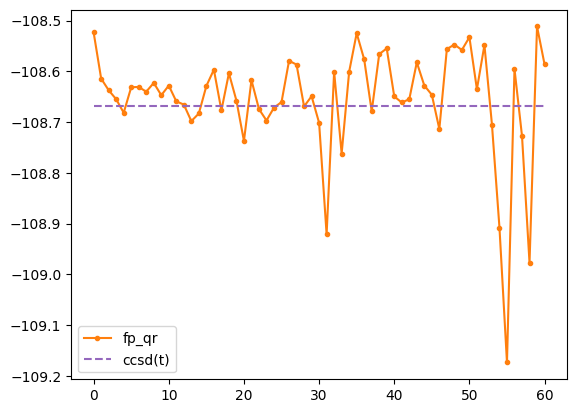

In [19]:
from matplotlib import pyplot as plt

# plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_qr2_e.real,'.-',label='fp_qr',color='C1')
plt.plot([mycc.e_tot + et]*len(fp_qr2_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [19]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w

    print(n+1, blk_e, blk_w)

1 (-108.61528818631066-0.0013499349152229214j) (251.00570000588368-1.1766479082502672e-16j)
2 (-108.61631812856511+0.005896502591359506j) (186.29794726105013-3.908150386420449e-16j)
3 (-108.63825662229745+0.010529003501254013j) (173.39270379934172+3.0513523184661327e-16j)
4 (-108.65284918761932+0.003324787425983546j) (172.5583901022995+4.471353145440311e-16j)
5 (-108.60875817917675+0.004091253575418307j) (290.3470308216754+1.581013785448571e-16j)
6 (-108.62852955540312-0.0029096363398706236j) (288.87506386770264-1.2055157501966156e-15j)
7 (-108.61776893623059-0.003380527874477396j) (1182.1008214384533+2.9470656043970223e-16j)
8 (-108.60774273109895-0.008495205428884647j) (312.7578097703092-1.314593593858482e-15j)
9 (-108.78053531232591-0.015005417187844842j) (39.22956967918476+2.562429983060334e-16j)
10 (-108.6730010260004+0.014671918224132462j) (48.28796140420046+3.8030193266092657e-16j)
11 (-108.64228123758458-0.005718493554643458j) (154.97727186493435-3.0128074372001037e-16j)
12 (-1

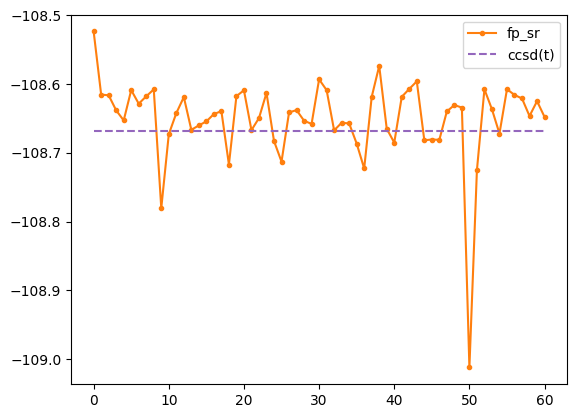

In [20]:
from matplotlib import pyplot as plt
# plt.plot(fp_qr2_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()

In [22]:
prop_data = init_prop(prop, trial, wave_data, ham_data, seed)
nstep = 60
fp_sr_e = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_w = np.zeros(nstep+1,dtype=np.complex128)
fp_sr_e[0] = prop_data["e_estimate"]
fp_sr_w[0] = sum(prop_data["weights"])
for n in range(nstep):
    prop_data, (blk_e, blk_w) = \
        fp_block_sr(prop_data, ham_data, prop, trial, wave_data, sampler)
    fp_sr_e[n+1] = blk_e
    fp_sr_w[n+1] = blk_w
    print(n+1, blk_e, blk_w)

1 (-108.61528818631068-0.0013499349152232124j) (112.14127996560904+1.7471804754568507e-16j)
2 (-108.61631812856514+0.005896502591357919j) (405.98915743706436-4.794656799748687e-16j)
3 (-108.6382566222974+0.010529003501253456j) (779.6469605254965+1.0568818615181494e-15j)
4 (-108.65284918761931+0.0033247874259836013j) (208.8567089903962+9.603937424866319e-16j)
5 (-108.60875817917673+0.004091253575417615j) (679.1884104769288-4.729462819828845e-15j)
6 (-108.62852955540312-0.0029096363398698954j) (653.4264149028272-1.1291996365319083e-15j)
7 (-108.61776893623059-0.0033805278744764213j) (100.59467794597934+5.0267028446565835e-16j)
8 (-108.60774273109892-0.008495205428883993j) (172.35896993667308+1.3782575420526764e-16j)
9 (-108.78053531232592-0.015005417187841104j) (106.57173643081015+5.539517604278128e-16j)
10 (-108.67300102600042+0.014671918224133513j) (105.29823740089886-2.709677375162583e-16j)
11 (-108.64228123758458-0.005718493554643197j) (230.46303808562755+1.8947428391002095e-16j)
12 

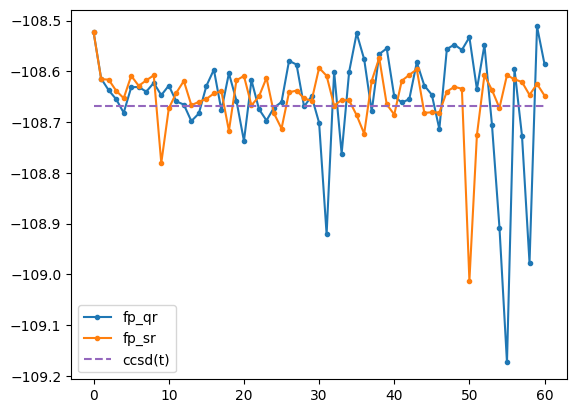

In [23]:
# plt.plot(fp_e.real,'.-',label='fp',color='C0')
plt.plot(fp_qr2_e.real,'.-',label='fp_qr',color='C0')
plt.plot(fp_sr_e.real,'.-',label='fp_sr',color='C1')
plt.plot([mycc.e_tot + et]*len(fp_sr_e), '--',label='ccsd(t)',color='C4')
plt.legend()
plt.show()